In [3]:
from PushTImageEnv import PushTImageEnv
from data_vision import PushTImageDataset, unnormalize_data, normalize_data
import torch as t
import torch
from torch import nn
import torchvision
import numpy as np
from conditional_unet1d import ConditionalUnet1D
from transformer_for_diffusion import TransformerForDiffusion
from diffusers.training_utils import EMAModel
from diffusers import DDPMScheduler, DDIMScheduler
from diffusers.optimization import get_scheduler
from tqdm.notebook import tqdm
import collections
import matplotlib.pyplot as plt

pygame 2.1.2 (SDL 2.0.16, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
def get_resnet(name:str, weights=None, **kwargs) -> nn.Module:
    """
    name: resnet18, resnet34, resnet50
    weights: "IMAGENET1K_V1", None
    """
    # Use standard ResNet implementation from torchvision
    func = getattr(torchvision.models, name)
    resnet = func(weights=weights, **kwargs)

    # remove the final fully connected layer
    # for resnet18, the output dim should be 512
    resnet.fc = torch.nn.Identity()
    return resnet


def replace_submodules(
        root_module: nn.Module, 
        predicate, 
        func) -> nn.Module:
    """
    Replace all submodules selected by the predicate with
    the output of func.

    predicate: Return true if the module is to be replaced.
    func: Return new module to use.
    """
    if predicate(root_module):
        return func(root_module)

    bn_list = [k.split('.') for k, m 
        in root_module.named_modules(remove_duplicate=True) 
        if predicate(m)]
    for *parent, k in bn_list:
        parent_module = root_module
        if len(parent) > 0:
            parent_module = root_module.get_submodule('.'.join(parent))
        if isinstance(parent_module, nn.Sequential):
            src_module = parent_module[int(k)]
        else:
            src_module = getattr(parent_module, k)
        tgt_module = func(src_module)
        if isinstance(parent_module, nn.Sequential):
            parent_module[int(k)] = tgt_module
        else:
            setattr(parent_module, k, tgt_module)
    # verify that all modules are replaced
    bn_list = [k.split('.') for k, m 
        in root_module.named_modules(remove_duplicate=True) 
        if predicate(m)]
    assert len(bn_list) == 0
    return root_module

def replace_bn_with_gn(
    root_module: nn.Module, 
    features_per_group: int=16) -> nn.Module:
    """
    Relace all BatchNorm layers with GroupNorm.
    """
    replace_submodules(
        root_module=root_module,
        predicate=lambda x: isinstance(x, nn.BatchNorm2d),
        func=lambda x: nn.GroupNorm(
            num_groups=x.num_features//features_per_group, 
            num_channels=x.num_features)
    )
    return root_module

In [49]:
# download demonstration data from Google Drive
dataset_path = "pusht_cchi_v7_replay.zarr"

# parameters
pred_horizon = 16
obs_horizon = 2
action_horizon = 8
#|o|o|                             observations: 2
#| |a|a|a|a|a|a|a|a|               actions executed: 8
#|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

# create dataset from file
dataset = PushTImageDataset(
    dataset_path=dataset_path,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon
)

stats = dataset.stats

# create dataloader
dataloader = t.utils.data.DataLoader(
    dataset,
    batch_size=256,
    num_workers=1,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=True 
)

In [321]:
# construct ResNet18 encoder
# if you have multiple camera views, use seperate encoder weights for each view.
vision_encoder = get_resnet('resnet18')

# IMPORTANT!
# replace all BatchNorm with GroupNorm to work with EMA
# performance will tank if you forget to do this!
vision_encoder = replace_bn_with_gn(vision_encoder)

# ResNet18 has output dim of 512
vision_feature_dim = 512
# agent_pos is 2 dimensional
lowdim_obs_dim = 2
# observation feature has 514 dims in total per step
obs_dim = vision_feature_dim + lowdim_obs_dim
action_dim = 2

noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon
)
noise_pred_net = noise_pred_net.to("cuda")

nets = nn.ModuleList([vision_encoder, noise_pred_net]).to("cuda")

ema = EMAModel(
    model=nets,
    power=0.75)

In [406]:
diffusion_timesteps = 100

noise_scheduler = DDPMScheduler(
    num_train_timesteps=diffusion_timesteps,
    beta_schedule='squaredcos_cap_v2',
    clip_sample=True,
    prediction_type='epsilon'
)

In [323]:
num_epochs = 20

optimizer = t.optim.AdamW(
    params=nets.parameters(),
    lr=1e-4, weight_decay=1e-6)

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(dataloader) * num_epochs
)

In [324]:
losses = []
for epoch in (e_iter := tqdm(range(num_epochs))):
    for batch in (b_iter := tqdm(dataloader, leave=False)):
        actions = batch["action"].to("cuda")
        images = batch["image"].to("cuda")
        pos = batch["agent_pos"].to("cuda")
        
        encoded_vectors = vision_encoder(images.reshape(-1, 3, 96, 96))
        encoded_vectors = encoded_vectors.reshape((images.shape[0], images.shape[1], -1))
        context = t.cat([encoded_vectors, pos], dim=-1).reshape(images.shape[0], -1)
        
        noise = t.randn(actions.shape, device="cuda")
        
        timesteps = t.randint(0, diffusion_timesteps, (len(actions),), device="cuda")
        noised_action = noise_scheduler.add_noise(actions, noise, timesteps)
        noise_pred = noise_pred_net(noised_action, timesteps, global_cond=context)
        
        loss = t.nn.functional.mse_loss(noise_pred, noise)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        lr_scheduler.step()
        ema.step(nets)
        b_iter.set_postfix({"Loss": loss.item()})
        losses.append(loss.item())

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

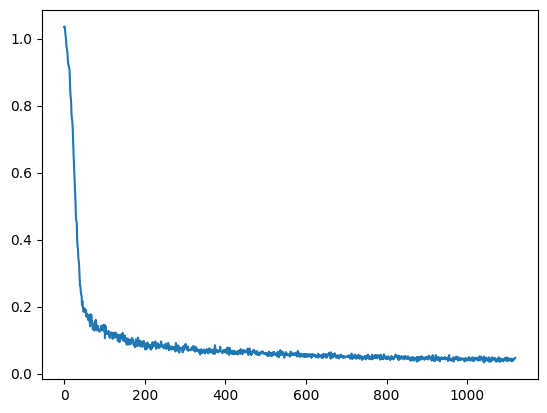

In [327]:
plt.plot(losses)

In [46]:
t.save(ema.averaged_model, "vision_model.pkl")

In [370]:
losses, vision_encoder, noise_pred_net = t.load("results_tuning/vision_results_diffusiontimesteps_200_tuning.pt", map_location=torch.device("cuda:1"))

In [47]:
# import pickle as pkl
# with open("results_tuning/vision_results_obs_horizon_2_tuning.pkl", "rb") as f:
#     losses, ema = pkl.load(f)
# ema_averaged_model = ema.averaged_model
# ema.averaged_model[0].to("cuda")
# ema.averaged_model[1].to("cuda")
# print()
ema_averaged_model = t.load("vision_model.pkl")

In [59]:
t.all(ema.averaged_model[1].conv1.weight == ema_averaged_model[1].conv1.weight)

AttributeError: 'ConditionalUnet1D' object has no attribute 'conv1'

In [328]:
with torch.inference_mode():
    # losses = []
    for epoch in (e_iter := tqdm(range(1))):
        for batch in (b_iter := tqdm(dataloader, leave=False)):
            actions = batch["action"].to("cuda")
            images = batch["image"].to("cuda")
            pos = batch["agent_pos"].to("cuda")

            encoded_vectors = vision_encoder(images.reshape(-1, 3, 96, 96))
            encoded_vectors = encoded_vectors.reshape((images.shape[0], images.shape[1], -1))
            context = t.cat([encoded_vectors, pos], dim=-1).reshape(images.shape[0], -1)

            noise = t.randn(actions.shape, device="cuda")

            timesteps = t.randint(0, diffusion_timesteps, (len(actions),), device="cuda")
            noised_action = noise_scheduler.add_noise(actions, noise, timesteps)
            noise_pred = noise_pred_net(noised_action, timesteps, global_cond=context)

            loss = t.nn.functional.mse_loss(noise_pred, noise)
            print(loss)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

tensor(0.0465, device='cuda:0')
tensor(0.0498, device='cuda:0')
tensor(0.0401, device='cuda:0')
tensor(0.0377, device='cuda:0')
tensor(0.0429, device='cuda:0')
tensor(0.0459, device='cuda:0')
tensor(0.0430, device='cuda:0')
tensor(0.0430, device='cuda:0')
tensor(0.0383, device='cuda:0')
tensor(0.0404, device='cuda:0')
tensor(0.0452, device='cuda:0')
tensor(0.0458, device='cuda:0')
tensor(0.0462, device='cuda:0')
tensor(0.0456, device='cuda:0')
tensor(0.0397, device='cuda:0')
tensor(0.0473, device='cuda:0')
tensor(0.0424, device='cuda:0')
tensor(0.0448, device='cuda:0')
tensor(0.0423, device='cuda:0')
tensor(0.0415, device='cuda:0')
tensor(0.0427, device='cuda:0')
tensor(0.0454, device='cuda:0')
tensor(0.0408, device='cuda:0')
tensor(0.0373, device='cuda:0')
tensor(0.0479, device='cuda:0')
tensor(0.0427, device='cuda:0')
tensor(0.0416, device='cuda:0')
tensor(0.0431, device='cuda:0')
tensor(0.0462, device='cuda:0')
tensor(0.0460, device='cuda:0')
tensor(0.0397, device='cuda:0')
tensor(0

In [72]:
#@markdown ### **Inference**

action_dim = 2

def run_inference(env, obs_horizon=obs_horizon, max_steps=200, device="cuda", stop_reward=0.9, action_horizon=action_horizon, diffusion_timesteps=100):
# # limit enviornment interaction to 200 steps before termination
# max_steps = 500
# env = PushTImageEnv()
# # use a seed >200 to avoid initial states seen in the training dataset
# env.seed(100000)

    # get first observation
    obs = env.reset()

    # keep a queue of last 2 steps of observations
    obs_deque = collections.deque(
        [obs] * obs_horizon, maxlen=obs_horizon)
    # save visualization and rewards
    imgs = []
    rewards = list()
    all_done = False
    step_idx = 0
    obs_list = [obs]
    
    noise_scheduler = DDPMScheduler(
        num_train_timesteps=diffusion_timesteps,
        beta_schedule='squaredcos_cap_v2',
        clip_sample=True,
        prediction_type='epsilon'
    )

    with tqdm(total=max_steps, desc="Eval PushTImageEnv") as pbar:
        while not all_done:
            B = len(env.env_fns)
            # stack the last obs_horizon number of observations
            images = np.stack([x['image'] for x in obs_deque])
            agent_poses = np.stack([x['agent_pos'] for x in obs_deque])
            
            # print(images.shape)

            # normalize observation
            nagent_poses = normalize_data(agent_poses, stats=stats['agent_pos'])
            # images are already normalized to [0,1]
            nimages = images

            # device transfer
            nimages = torch.from_numpy(nimages).to(device, dtype=torch.float32)
            # (2,3,96,96)
            nagent_poses = torch.from_numpy(nagent_poses).to(device, dtype=torch.float32)
            # (2,2)

            # infer action
            with torch.no_grad():
                # get image features
                # print(nimages.shape)
                image_features = vision_encoder(nimages.reshape(B * obs_horizon, 3, 96, 96)).reshape(obs_horizon, B, -1)
                # print(image_features.shape)
                # (2,512)
                # print(nagent_poses.shape)
                # concat with low-dim observations
                obs_features = torch.cat([image_features, nagent_poses], dim=-1)

                # reshape observation to (B,obs_horizon*obs_dim)
                obs_cond = obs_features.permute(1, 0, 2).flatten(start_dim=1)#.unsqueeze(0).flatten(start_dim=1)

                # initialize action from Guassian noise
                noisy_action = torch.randn(
                    (B, pred_horizon, action_dim), device=device)
                naction = noisy_action

                # init scheduler
                noise_scheduler.set_timesteps(diffusion_timesteps)

                for k in noise_scheduler.timesteps:
                    # predict noise
                    noise_pred = noise_pred_net(
                        sample=naction,
                        timestep=k,
                        global_cond=obs_cond
                    )

                    # inverse diffusion step (remove noise)
                    naction = noise_scheduler.step(
                        model_output=noise_pred,
                        timestep=k,
                        sample=naction
                    ).prev_sample
    
            # unnormalize action
            naction = naction.detach().to('cpu').numpy()
            # (B, pred_horizon, action_dim)
            action_pred = unnormalize_data(naction, stats=stats['action'])

            # only take action_horizon number of actions
            start = obs_horizon - 1
            end = start + action_horizon
            action = action_pred[:, start:end,:]
            # (action_horizon, action_dim)

            # execute action_horizon number of steps
            # without replanning
            for i in range((action.shape[1])):
                # stepping env
                obs, reward, done, info = env.step(action[:, i])
                # save observations
                obs_deque.append(obs)
                obs_list.append(obs)
                # and reward/vis
                rewards.append(reward)
                imgs.append(env.render(mode = 'rgb_array'))

                # update progress bar
                step_idx += 1
                pbar.update(1)
                pbar.set_postfix(reward=reward)
                if step_idx > max_steps:
                    all_done = True
                    break
                # if t.all(done):
                #     break
    return rewards, imgs, obs_list

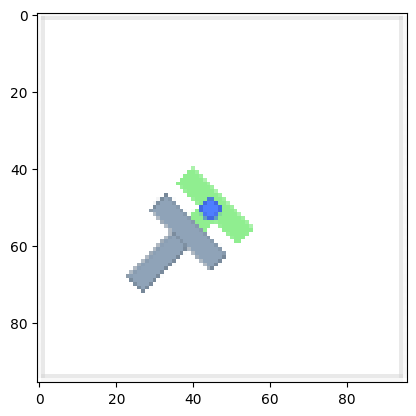

In [70]:
# env = PushTImageEnv(reset_to_state=np.array([150, 350, 350, 150, np.pi/4]))
env = PushTImageEnv(reset_to_state=np.array([350-110, 163+110, 150+70, 363-70, np.pi/4]))
# use a seed >200 to avoid initial states seen in the training dataset
env.seed(300)
env.reset()
plt.imshow(env.render(mode='rgb_array'))
plt.show()

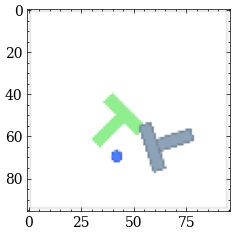

In [592]:
# env = PushTImageEnv(reset_to_state=np.array([150, 350, 350, 150, np.pi/4]))
env = PushTImageEnv()
# use a seed >200 to avoid initial states seen in the training dataset
# env.seed(300)
env.reset()
plt.imshow(env.render(mode='rgb_array'))
plt.show()

In [210]:
horizons = [1, 2, 4, 8]
filenames = [f"results_tuning/vision_results_obs_horizon_{i}_tuning.pt" for i in horizons]

In [25]:
from async_vector_env import AsyncVectorEnv
# from gym.vector import AsyncVectorEnv

In [198]:
import functools
# pusht = functools.partial(PushTImageEnv, reset_to_state=np.array([350-110, 163+110, 150+70, 363-70, np.pi/4]))
pusht = functools.partial(PushTImageEnv, reset_to_state=np.array([350-207, 163+210, 150+150, 363-150, np.pi/4]))

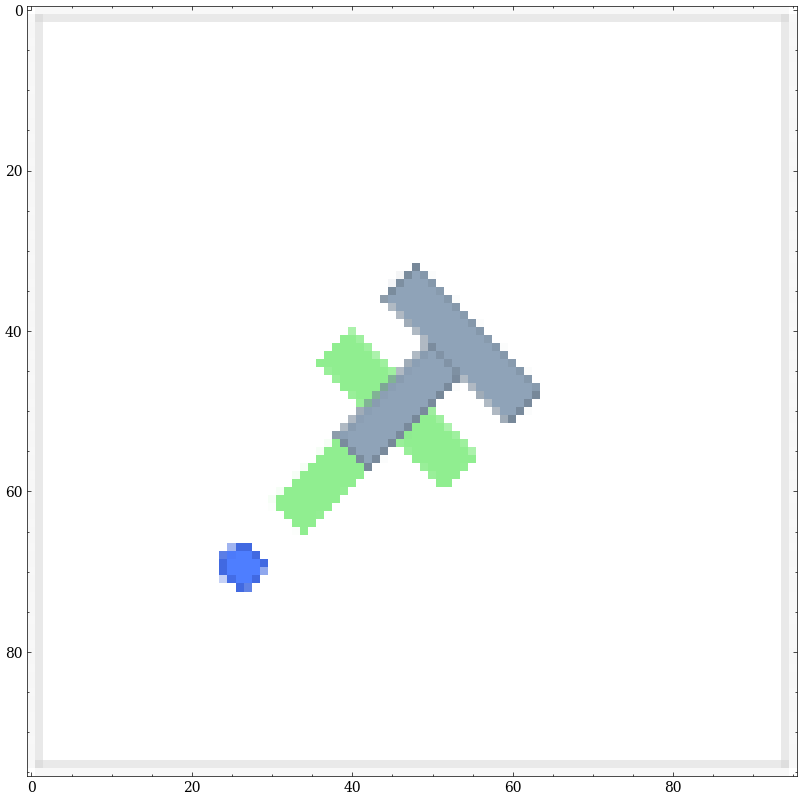

In [199]:
plt.figure(figsize=(10, 10))
plt.imshow(pusht().reset()["image"].transpose(1, 2, 0))
plt.show()

In [ ]:
losses, vision_encoder, noise_pred_net = t.load("results_tuning/vision_results_best.pt", map_location=torch.device("cuda:0"))
    
env = AsyncVectorEnv([PushTImageEnv for i in range(200)])
env.seed(np.random.randint(500, 10000, len(env.env_fns)))

rewards, imgs, obs_list = run_inference(env, obs_horizon=2, action_horizon=8, max_steps=200, diffusion_timesteps=100, device="cuda:0", stop_reward=1)

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

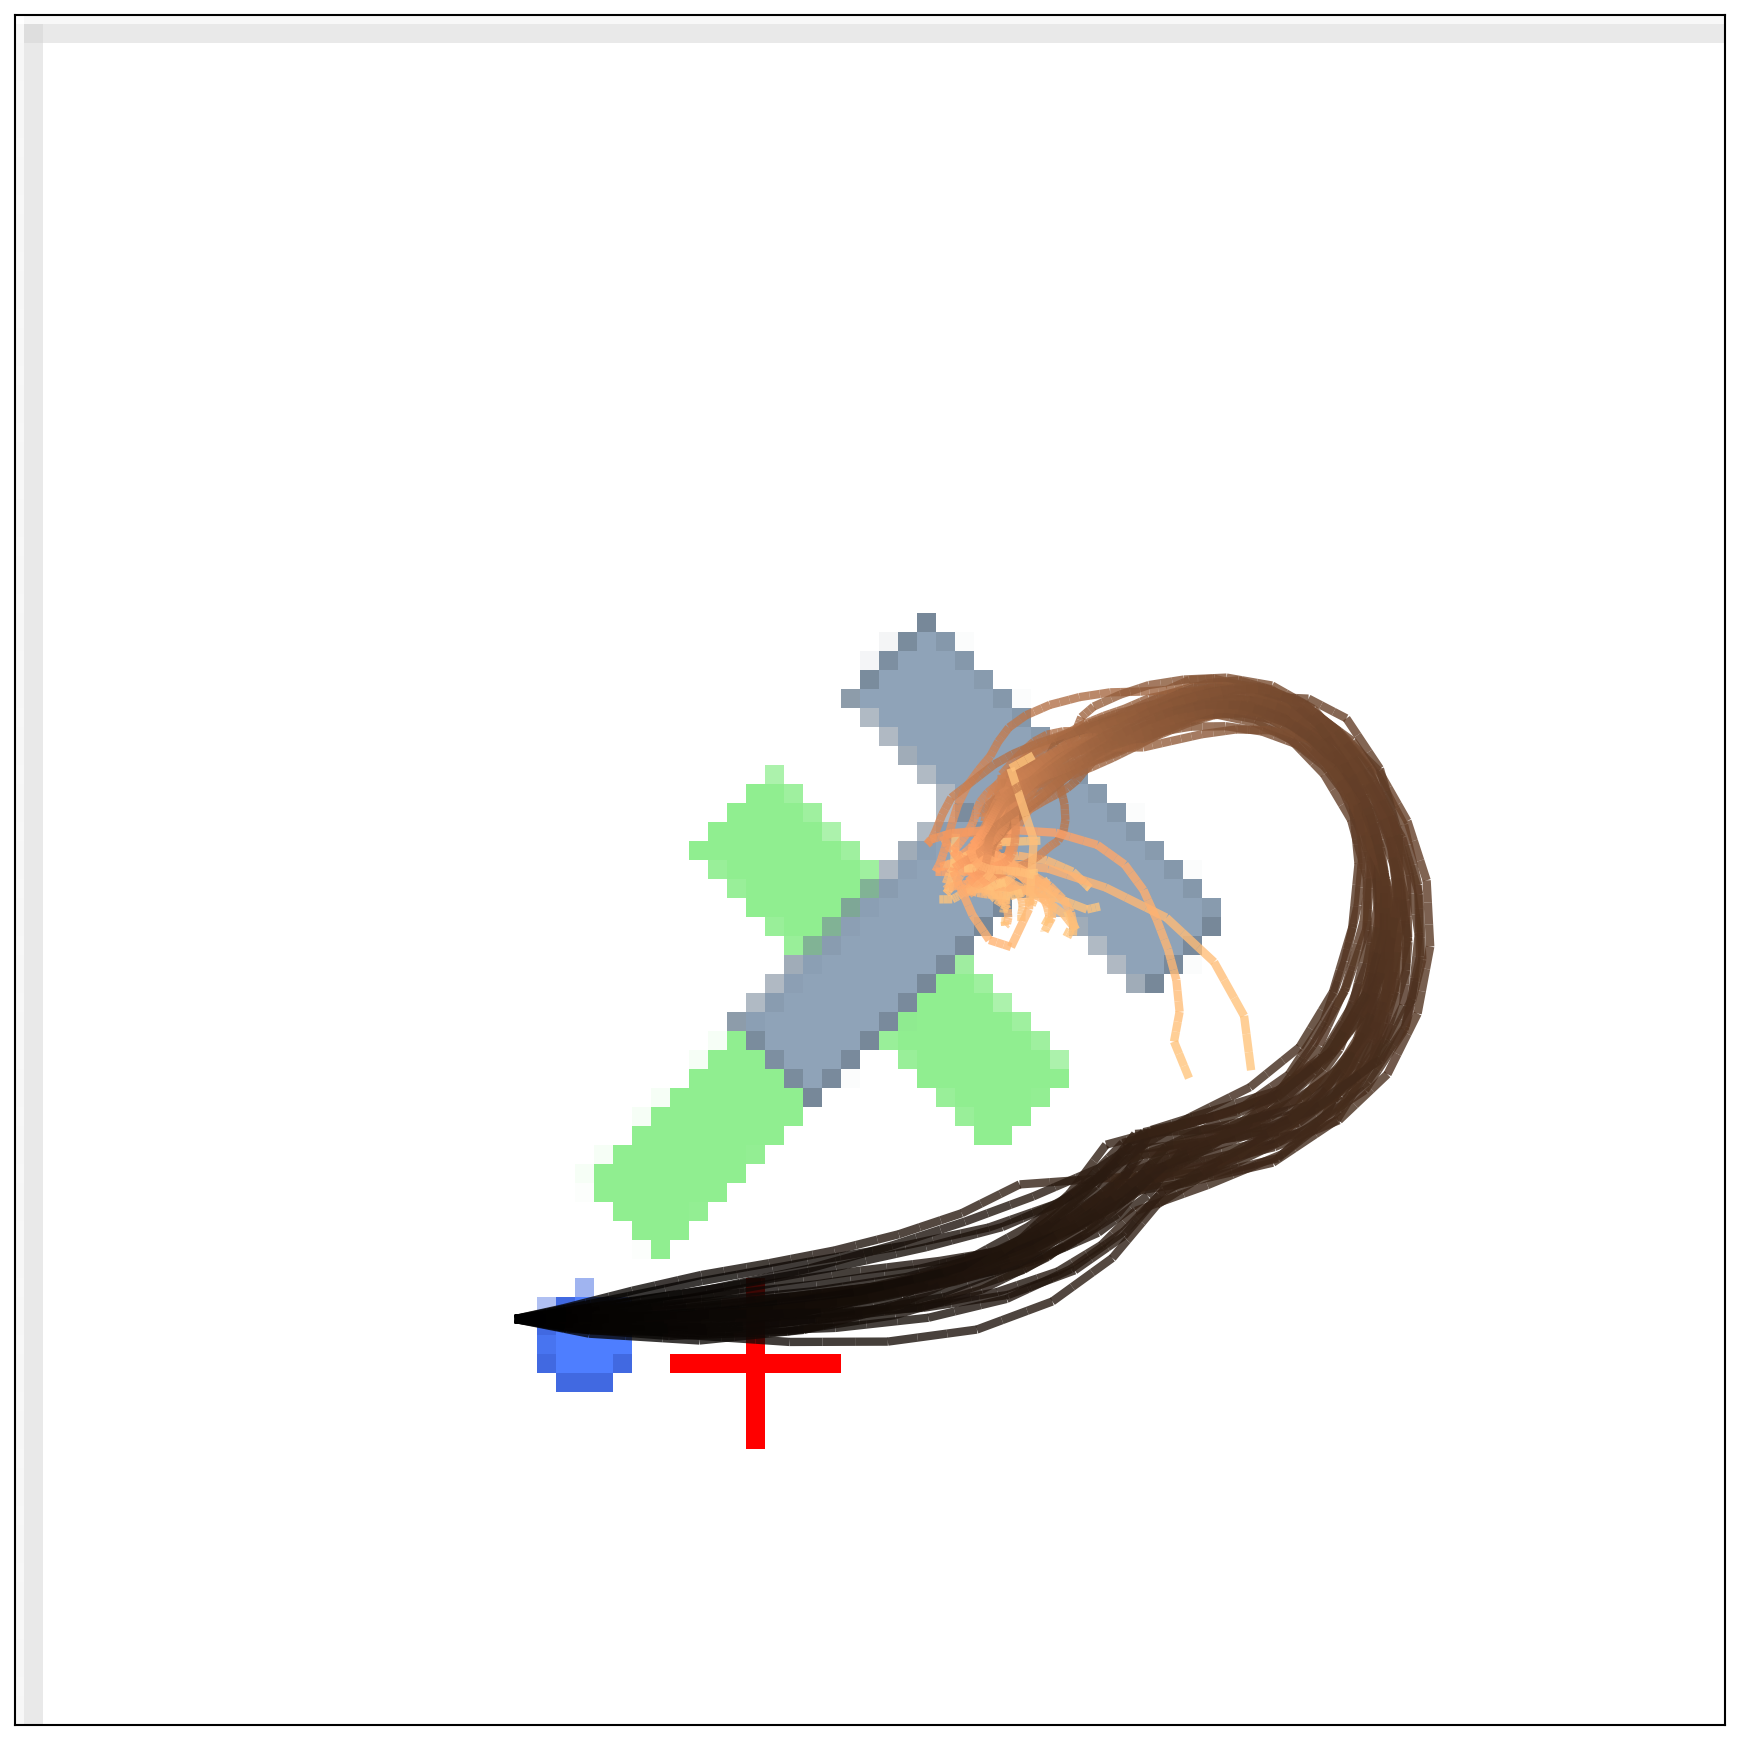

In [206]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6), dpi=300)
positional_data = []
for l in obs_list:
    positional_data.append(l["agent_pos"])
positional_data = np.array(positional_data)
positional_data = positional_data.transpose(1, 2, 0)

ax = axs

for j in range(len(positional_data)):
    plot_path(*positional_data[j][:, :50]/(500/92), ax)

ax.imshow(imgs[0][0])
ax.set_aspect('equal')
ax.set_xlim(0, 90)
ax.set_ylim(0, 90)
ax.invert_yaxis()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax.set_title(f"Obs Horizon: {horizons[i]}")
plt.tight_layout()
plt.show()

In [33]:
np.array(imgs)[:, 0].shape

(201, 96, 96, 3)

In [34]:
from skvideo.io import vwrite
vwrite("test.mp4", np.array(imgs)[:, 0])

In [73]:
np.mean(np.max(np.array(rewards).T, axis=1))

0.650703757860804

In [196]:
full_rewards_static = []
full_images_static = []
full_obs_static = []
full_losses_static = []
for i, filename in tqdm(list(enumerate(filenames))):
    losses, vision_encoder, noise_pred_net = t.load(filename, map_location=torch.device("cuda:0"))
    full_losses.append(losses)
    env = AsyncVectorEnv([pusht for i in range(30)])
    env.seed(np.random.randint(500, 1000, len(env.env_fns)))
    
    rewards, imgs, obs_list = run_inference(env, obs_horizon=horizons[i], action_horizon=8, max_steps=200, diffusion_timesteps=100, device="cuda:0", stop_reward=1)
    
    full_rewards_static.append(rewards)
    full_images_static.append(imgs)
    full_obs_static.append(obs_list)

  0%|          | 0/4 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

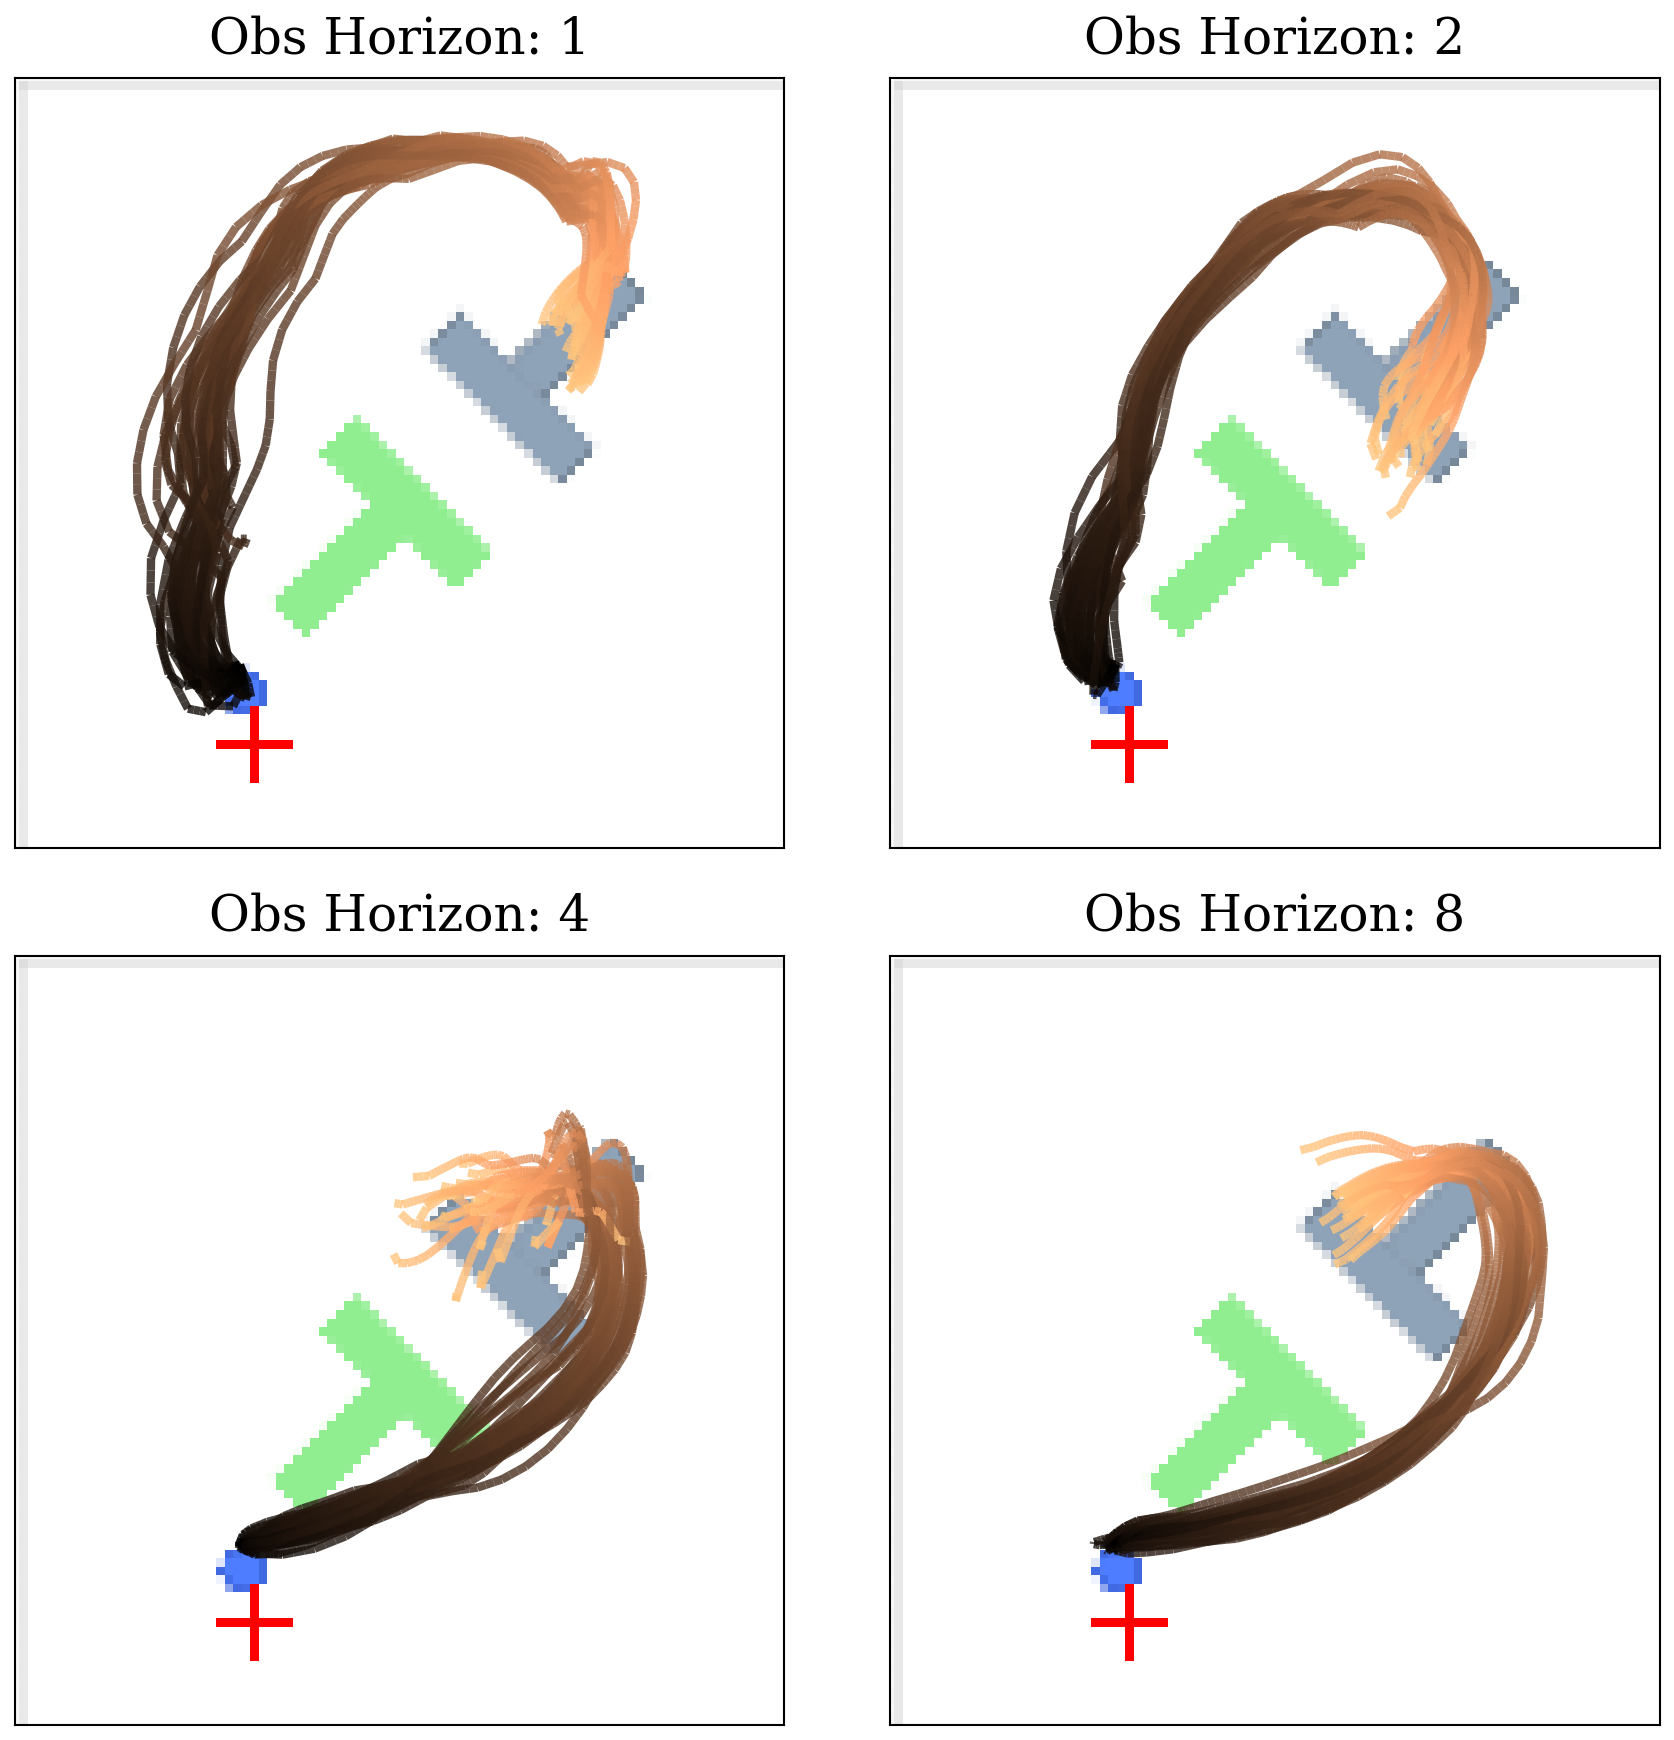

In [197]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), dpi=300)
for i in range(len(full_obs_static)):
    all_obs = full_obs_static[i]
    positional_data = []
    for obs_list in all_obs:
        positional_data.append(obs_list["agent_pos"])
        # for obs in obs_list:
        #     positional_data[-1].append(obs["agent_pos"])
        # positional_data[-1] = np.array(positional_data[-1]).T
        
    # print(np.array(positional_data).shape)
    positional_data = np.array(positional_data)
    positional_data = positional_data.transpose(1, 2, 0)
    
    ax = axs.flat[i]
    
    for j in range(len(positional_data)):
        plot_path(*positional_data[j][:, :50]/(500/92), ax)
    
    ax.imshow(full_images_static[0][0][0])
    ax.set_aspect('equal')
    ax.set_xlim(0, 90)
    ax.set_ylim(0, 90)
    ax.invert_yaxis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Obs Horizon: {horizons[i]}")
plt.tight_layout()
plt.show()

In [211]:
full_rewards = []
full_images = []
full_obs = []
full_losses = []
for i, filename in tqdm(list(enumerate(filenames))):
    losses, vision_encoder, noise_pred_net = t.load(filename, map_location=torch.device("cuda:0"))
    full_losses.append(losses)
    env = AsyncVectorEnv([PushTImageEnv for i in range(200)])
    env.seed(np.random.randint(500, 1000, len(env.env_fns)))
    
    rewards, imgs, obs_list = run_inference(env, obs_horizon=horizons[i], action_horizon=8, max_steps=200, diffusion_timesteps=100, device="cuda:0", stop_reward=1)
    
    full_rewards.append(rewards)
    full_images.append(imgs)
    full_obs.append(obs_list)

  0%|          | 0/4 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

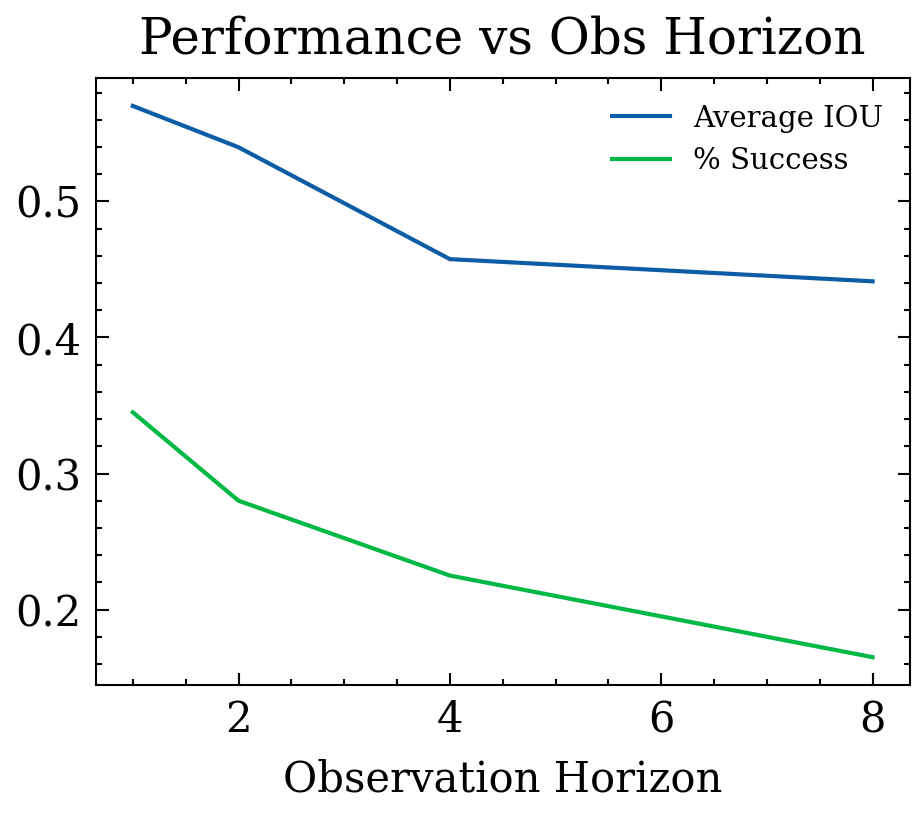

In [212]:
best_rewards = []

average_bests = []
perc_success = []
for rewards in full_rewards:
    rewards = np.array(rewards)
    top_rewards = np.max(rewards, axis=0)
    average_bests.append(np.mean(top_rewards))
    perc_success.append(np.sum(top_rewards > 0.9) / len(top_rewards))

plt.figure(dpi=300)
plt.plot(horizons, average_bests, label="Average IOU")
plt.plot(horizons, perc_success, label="% Success")
# plt.axhline(0.64, ls="--", c="purple", label="Avg IoU Baseline")
plt.legend(fontsize=7)
plt.xlabel("Observation Horizon")
plt.title("Performance vs Obs Horizon")
plt.show()

# plt.figure()
# plt.show()

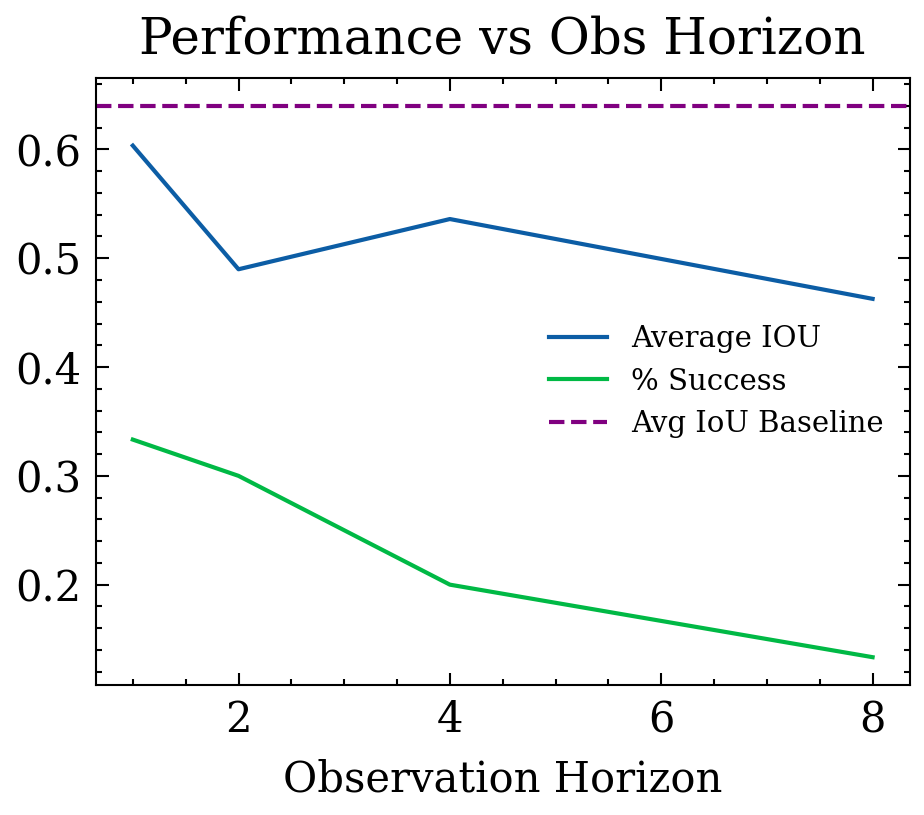

In [100]:
best_rewards = []

average_bests = []
perc_success = []
for rewards in full_rewards:
    rewards = np.array(rewards)
    top_rewards = np.max(rewards, axis=0)
    average_bests.append(np.mean(top_rewards))
    perc_success.append(np.sum(top_rewards > 0.9) / len(top_rewards))

plt.figure(dpi=300)
plt.plot(horizons, average_bests, label="Average IOU")
plt.plot(horizons, perc_success, label="% Success")
# plt.axhline(0.64, ls="--", c="purple", label="Avg IoU Baseline")
plt.legend(fontsize=7)
plt.xlabel("Observation Horizon")
plt.title("Performance vs Obs Horizon")
plt.show()

# plt.figure()
# plt.show()

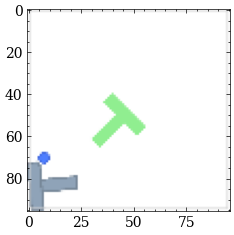

In [726]:
plt.figure()
plt.imshow(imgs[400][1].transpose(1, 2, 0))
plt.show()

In [435]:
full_rewards = []
full_images = []
full_obs = []
full_losses = []
for i, filename in tqdm(enumerate(filenames)):
    losses, vision_encoder, noise_pred_net = t.load(filename, map_location=torch.device("cuda:0"))
    full_losses.append(losses)
    
    all_rewards = []
    all_imgs = []
    all_obs = []
    for j in tqdm(range(20)):
        env = PushTImageEnv()
        env.reset()
        rewards, imgs, obs_list = run_inference(env, obs_horizon=horizons[i], action_horizon=8, max_steps=200, diffusion_timesteps=100, device="cuda:0", stop_reward=1)
        all_rewards.append(rewards)
        all_imgs.append(imgs)
        all_obs.append(obs_list)
    full_rewards.append(all_rewards)
    full_images.append(all_imgs)
    full_obs.append(all_obs)

  0%|          | 0/10 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

Eval PushTImageEnv:   0%|          | 0/200 [00:00<?, ?it/s]

In [78]:
import scienceplots
plt.style.use('science')

In [79]:
plt.rcParams['text.usetex'] = False

In [102]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

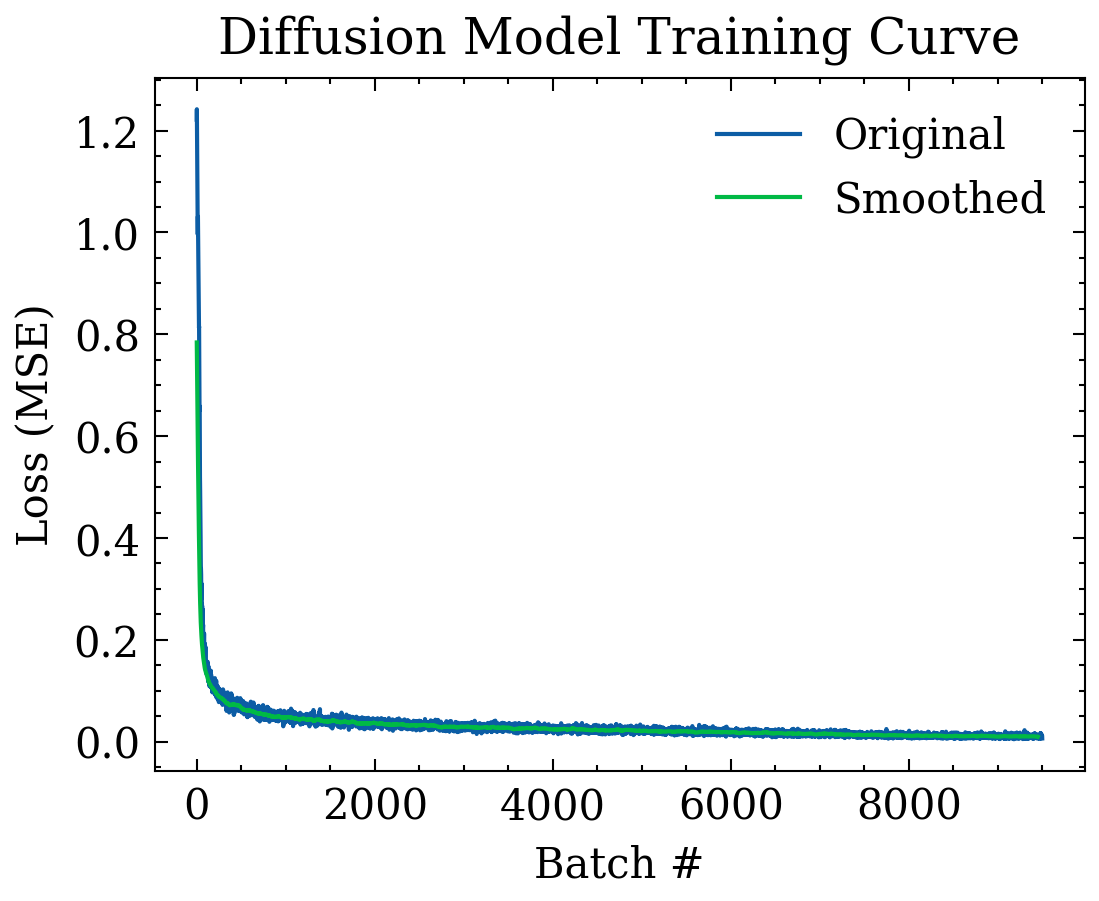

In [103]:
mainmodel_loss = full_losses[1]
plt.figure(figsize=(4, 3), dpi=300)
plt.plot(mainmodel_loss, label="Original")
plt.plot(moving_average(mainmodel_loss, 50), label="Smoothed")
plt.ylabel("Loss (MSE)")
plt.xlabel("Batch #")
plt.title("Diffusion Model Training Curve")
plt.legend()
plt.show()

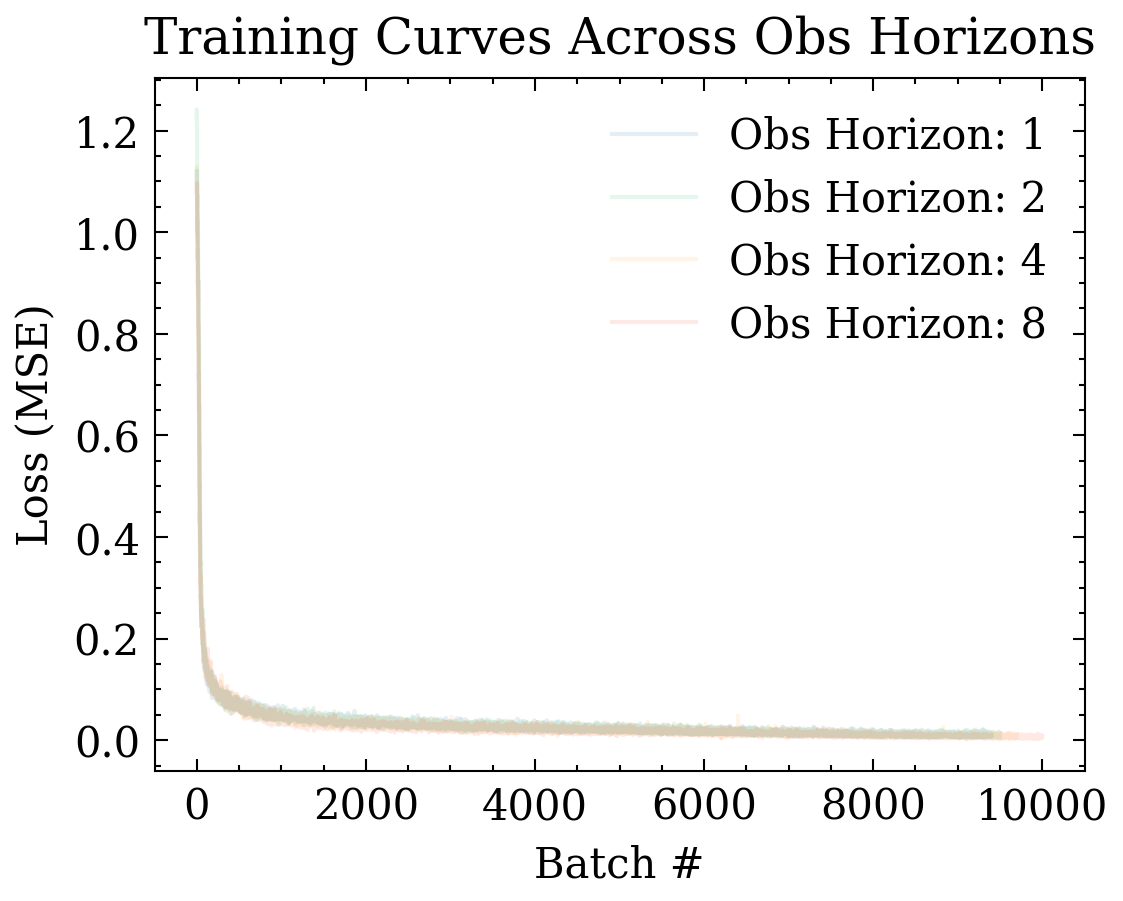

In [496]:
plt.figure(figsize=(4, 3), dpi=300)
for i, loss in enumerate(full_losses):
    plt.plot(loss, label=f"Obs Horizon: {horizons[i]}", alpha=0.1)
plt.ylabel("Loss (MSE)")
plt.xlabel("Batch #")
plt.title("Training Curves Across Obs Horizons")
plt.legend()
plt.show()

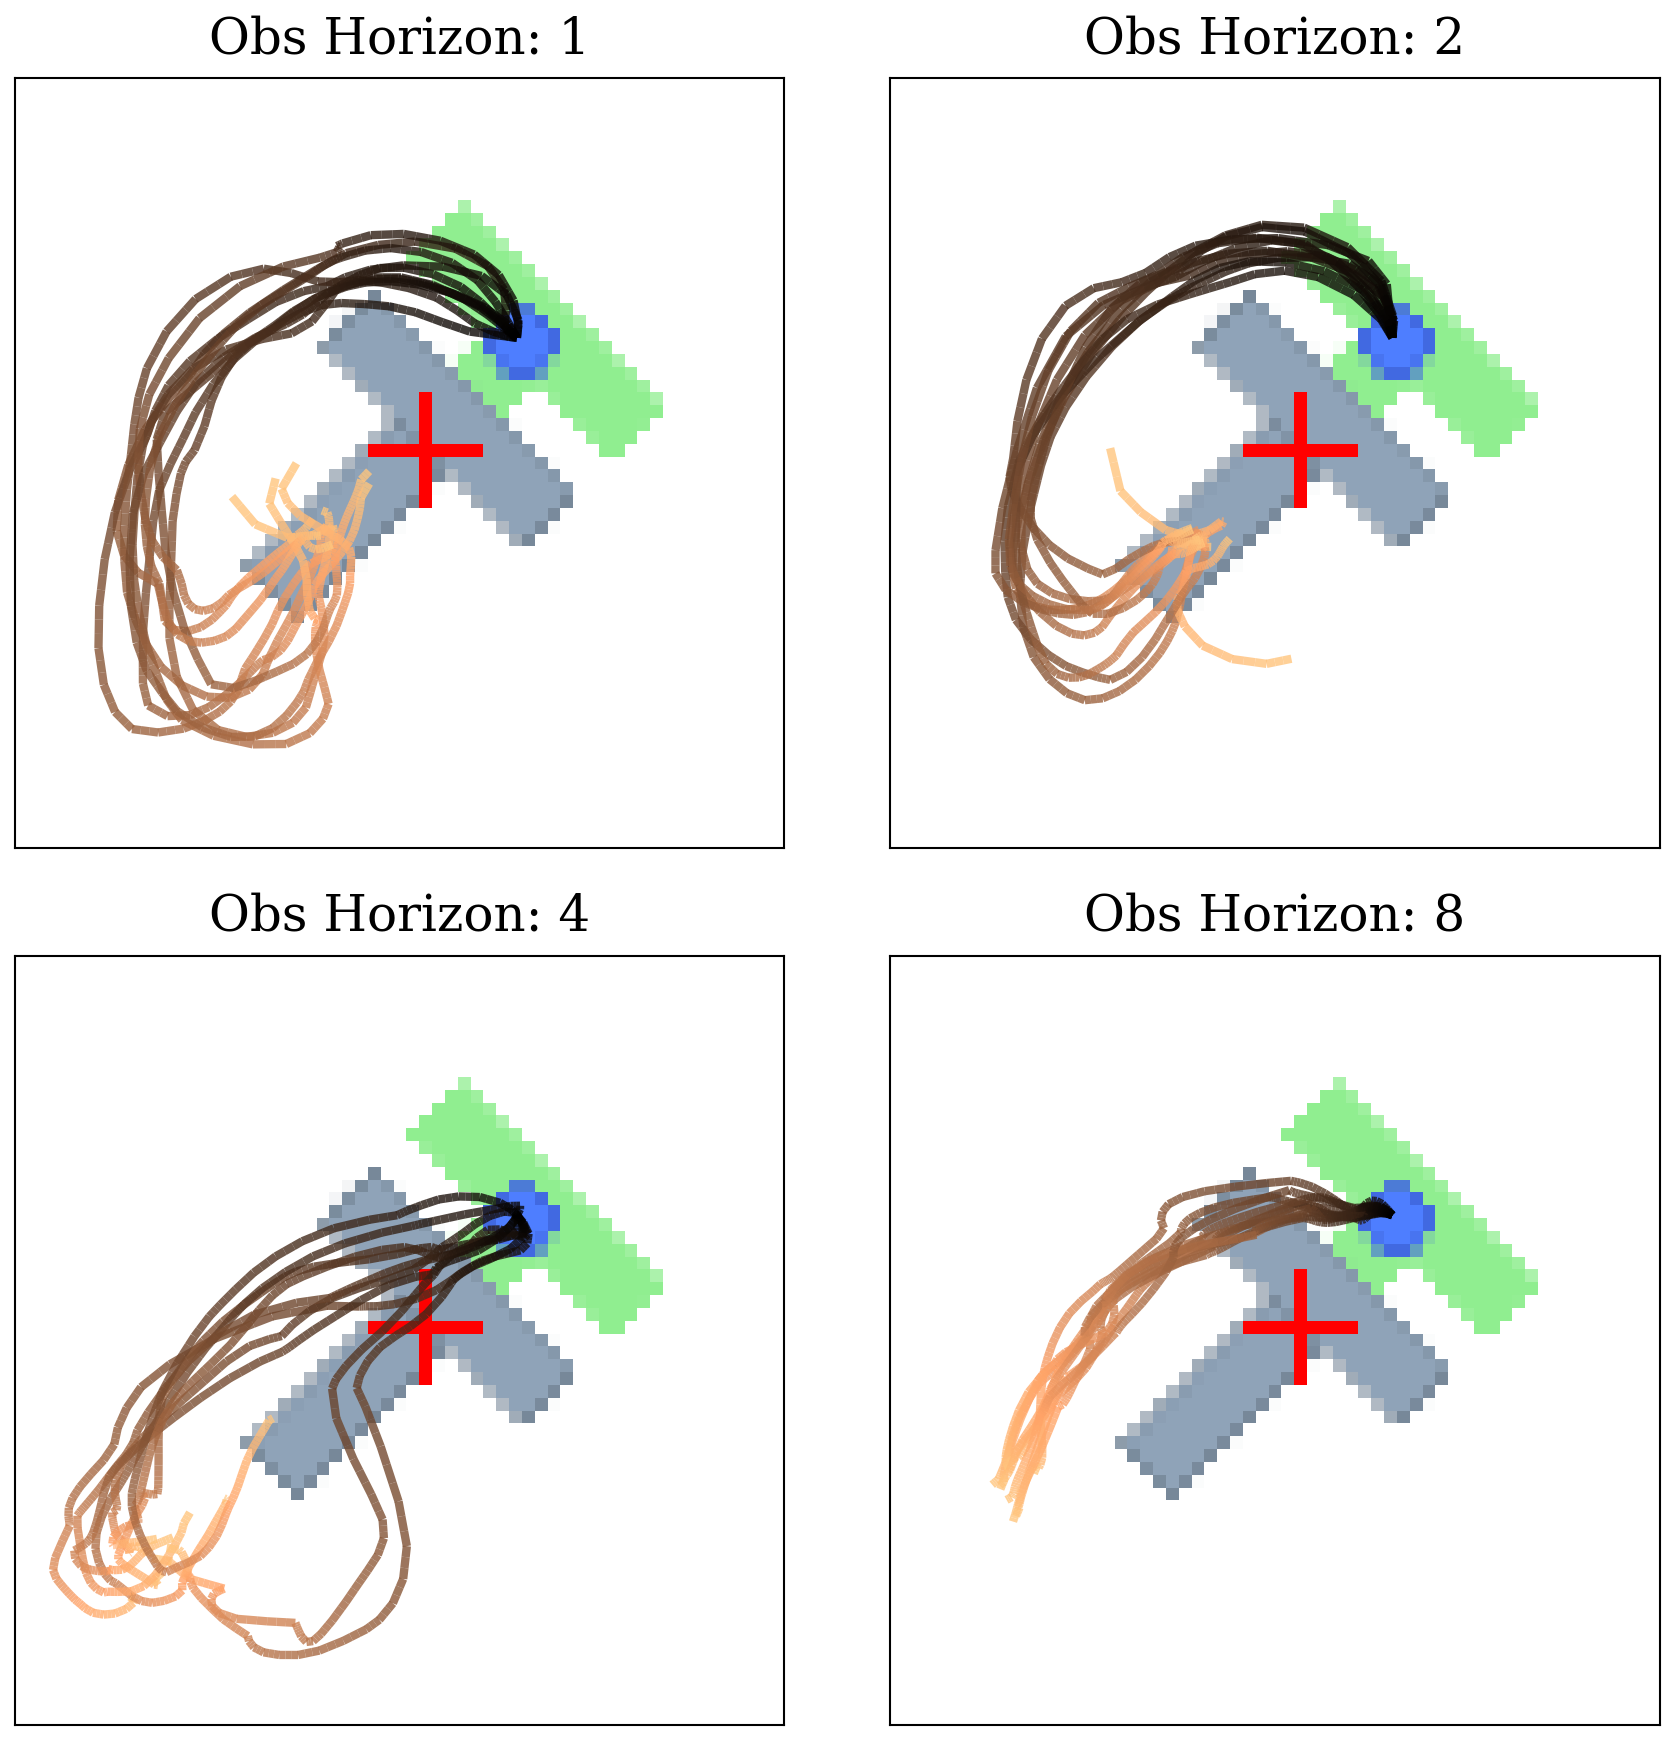

In [544]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), dpi=300)
for i in range(len(full_obs)):
    all_obs = full_obs[i]
    positional_data = []
    for obs_list in all_obs:
        positional_data.append([])
        for obs in obs_list:
            positional_data[-1].append(obs["agent_pos"])
        positional_data[-1] = np.array(positional_data[-1]).T
    
    ax = axs.flat[i]
    
    for j in range(len(positional_data)):
        plot_path(*positional_data[j][:, :50]/(500/92), ax)
    
    ax.imshow(all_imgs[0][0])
    ax.set_aspect('equal')
    ax.set_xlim(5, 65)
    ax.set_ylim(30, 90)
    ax.invert_yaxis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Obs Horizon: {horizons[i]}")
plt.tight_layout()
plt.show()

In [213]:
full_rewards_action_sweep = []
full_images_action_sweep = []
full_obs_action_sweep = []
losses, vision_encoder, noise_pred_net = t.load(filenames[0], map_location=torch.device("cuda:0"))
for action_horizon in tqdm([2, 4, 8, 16, 32]):
    env = AsyncVectorEnv([PushTImageEnv for i in range(200)])
    env.seed(np.random.randint(500, 10000, len(env.env_fns)))
    
    rewards, imgs, obs_list = run_inference(env, obs_horizon=1, action_horizon=action_horizon, max_steps=200, diffusion_timesteps=100, device="cuda:0", stop_reward=1)
    
    full_rewards_action_sweep.append(rewards)
    full_images_action_sweep.append(imgs)
    full_obs_action_sweep.append(obs_list)

  0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _releaseLock at 0x7ff83234c280>
Traceback (most recent call last):
  File "/data/vision/torralba/graphphys/miniconda3/envs/cloned/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Exception ignored in: <function _releaseLock at 0x7ff83234c280>
Traceback (most recent call last):
  File "/data/vision/torralba/graphphys/miniconda3/envs/cloned/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Exception ignored in: <function _releaseLock at 0x7ff83234c280>
Traceback (most recent call last):
  File "/data/vision/torralba/graphphys/miniconda3/envs/cloned/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Exception ignored in: <function Socket.__del__ at 0x7ff831ce7010>
Traceback (most recent call last):
  File "/data/vision/torralba/graphphys/miniconda3/envs/cloned/lib/python3.10/site-packages/

BrokenPipeError: [Errno 32] Broken pipe

Exception ignored in: <function Socket.__del__ at 0x7ff831ce7010>
Traceback (most recent call last):
  File "/data/vision/torralba/graphphys/miniconda3/envs/cloned/lib/python3.10/site-packages/zmq/sugar/socket.py", line 110, in __del__
    def __del__(self):
KeyboardInterrupt: 
Exception ignored in: <function Socket.__del__ at 0x7ff831ce7010>
Traceback (most recent call last):
  File "/data/vision/torralba/graphphys/miniconda3/envs/cloned/lib/python3.10/site-packages/zmq/sugar/socket.py", line 110, in __del__
    def __del__(self):
KeyboardInterrupt: 
Exception ignored in sys.unraisablehook: <built-in function unraisablehook>
Traceback (most recent call last):
  File "/data/vision/torralba/graphphys/miniconda3/envs/cloned/lib/python3.10/site-packages/ipykernel/iostream.py", line 488, in flush
    if not evt.wait(self.flush_timeout):
  File "/data/vision/torralba/graphphys/miniconda3/envs/cloned/lib/python3.10/threading.py", line 607, in wait
    signaled = self._cond.wait(timeout)
  Fi

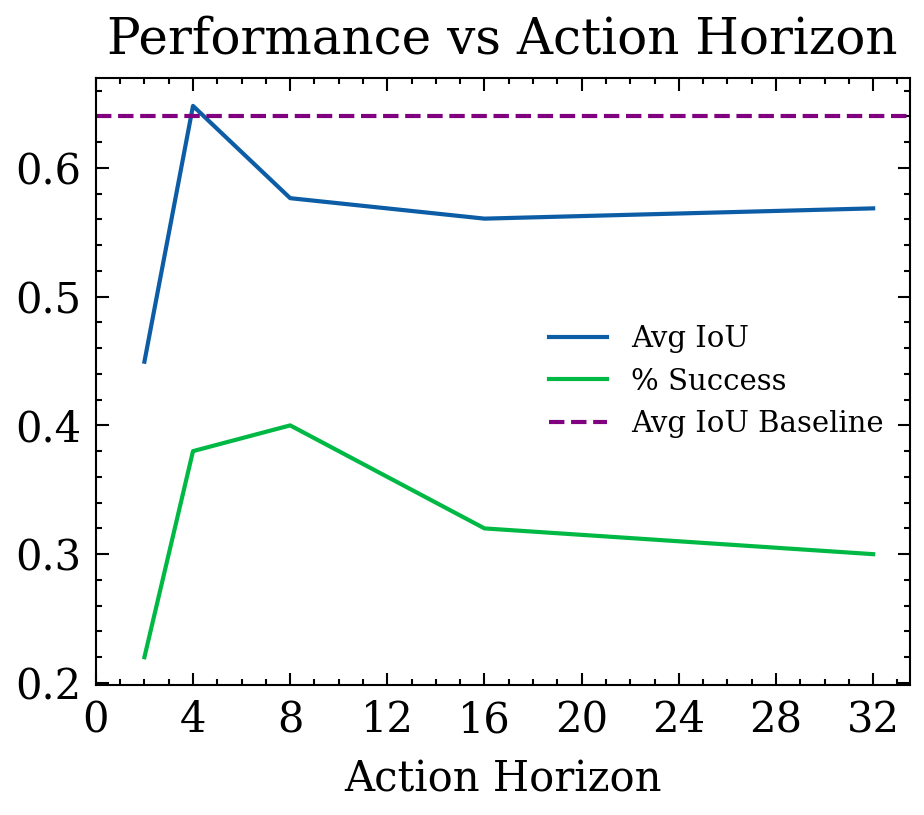

In [99]:
best_rewards = []

average_bests = []
perc_success = []
for rewards in full_rewards_action_sweep:
    rewards = np.array(rewards)
    top_rewards = np.max(rewards, axis=0)
    average_bests.append(np.mean(top_rewards))
    perc_success.append(np.sum(top_rewards > 0.9) / len(top_rewards))

plt.figure(dpi=300)
plt.plot([2, 4, 8, 16, 32], average_bests, label="Avg IoU")
plt.plot([2, 4, 8, 16, 32], perc_success, label="% Success")
plt.axhline(0.64, ls="--", c="purple", label="Avg IoU Baseline")
plt.legend(fontsize=7)
plt.xlabel("Action Horizon")
plt.title("Performance vs Action Horizon")
plt.yticks()
plt.xticks(range(0, 34, 4))
plt.show()

In [111]:
from skvideo.io import vwrite
vwrite("vis.mp4", all_imgs[1])

In [317]:
positional_data = []
for obs_list in all_obs:
    positional_data.append([])
    for obs in obs_list:
        positional_data[-1].append(obs["agent_pos"])
    positional_data[-1] = np.array(positional_data[-1]).T

In [147]:
def plot_path(x, y, ax=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.collections as mcoll
    import matplotlib.path as mpath

    def colorline(
        x, y, z=None, cmap=plt.get_cmap('inferno'), norm=plt.Normalize(0.0, 1.0),
            linewidth=1, alpha=0.8, ax=None):
        """
        http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
        http://matplotlib.org/examples/pylab_examples/multicolored_line.html
        Plot a colored line with coordinates x and y
        Optionally specify colors in the array z
        Optionally specify a colormap, a norm function and a line width
        """

        # Default colors equally spaced on [0,1]:
        if z is None:
            z = np.linspace(0.0, 1.0, len(x))

        # Special case if a single number:
        if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
            z = np.array([z])

        z = np.asarray(z)

        segments = make_segments(x, y)
        lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                                  linewidth=linewidth, alpha=alpha)

        if ax is None:
            ax = plt.gca()
        ax.add_collection(lc)

        return lc


    def make_segments(x, y):
        """
        Create list of line segments from x and y coordinates, in the correct format
        for LineCollection: an array of the form numlines x (points per line) x 2 (x
        and y) array
        """

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        return segments

    path = mpath.Path(np.column_stack([x, y]))
    verts = path.interpolated(steps=3).vertices
    x, y = verts[:, 0], verts[:, 1]
    z = np.linspace(0, 1, len(x))
    colorline(x, y, z, cmap=plt.get_cmap('copper'), linewidth=2, ax=ax)

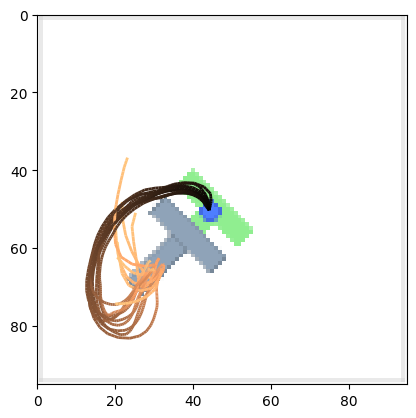

In [346]:
for i in range(len(positional_data)):
    plot_path(*positional_data[i][:, :50]/(500/92))
plt.imshow(all_imgs[0][0])
ax = plt.gca()
ax.set_aspect('equal')
ax.set_xlim(0, 95)
ax.set_ylim(0, 95)
ax.invert_yaxis()

In [407]:
diffusion_timesteps = 200

noise_scheduler = DDPMScheduler(
    num_train_timesteps=diffusion_timesteps,
    beta_schedule='squaredcos_cap_v2',
    clip_sample=True,
    prediction_type='epsilon'
)

In [408]:
# get first observation
obs = env.reset()

# keep a queue of last 2 steps of observations
obs_deque = collections.deque(
    [obs] * obs_horizon, maxlen=obs_horizon)
# save visualization and rewards
imgs = [env.render(mode='rgb_array')]
rewards = list()
done = False
step_idx = 0
obs_list = [obs]

B = 1
# stack the last obs_horizon number of observations
images = np.stack([x['image'] for x in obs_deque])
agent_poses = np.stack([x['agent_pos'] for x in obs_deque])

# normalize observation
nagent_poses = normalize_data(agent_poses, stats=stats['agent_pos'])
# images are already normalized to [0,1]
nimages = images

# device transfer
nimages = torch.from_numpy(nimages).to(device, dtype=torch.float32)
# (2,3,96,96)
nagent_poses = torch.from_numpy(nagent_poses).to(device, dtype=torch.float32)
# (2,2)

# infer action
with torch.no_grad():
    # get image features
    image_features = vision_encoder(nimages)
    # (2,512)

    # concat with low-dim observations
    obs_features = torch.cat([image_features, nagent_poses], dim=-1)

    # reshape observation to (B,obs_horizon*obs_dim)
    obs_cond = obs_features.unsqueeze(0).flatten(start_dim=1)

    # initialize action from Guassian noise
    noisy_action = torch.randn(
        (B, pred_horizon, action_dim), device=device)
    naction = noisy_action

    # init scheduler
    noise_scheduler.set_timesteps(diffusion_timesteps)
    
    all_positions = []

    for k in noise_scheduler.timesteps:
        # predict noise
        noise_pred = noise_pred_net(
            sample=naction,
            timestep=k,
            global_cond=obs_cond
        )

        # inverse diffusion step (remove noise)
        naction = noise_scheduler.step(
            model_output=noise_pred,
            timestep=k,
            sample=naction
        ).prev_sample
        positions = unnormalize_data(naction.cpu(), stats["action"])
        all_positions.append(positions)

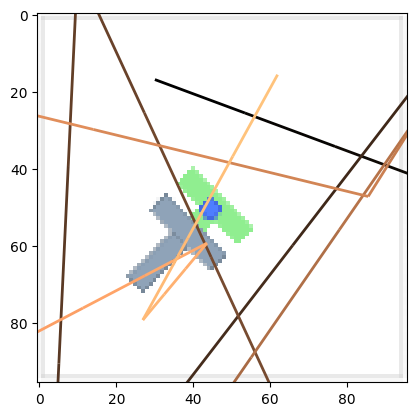

In [424]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0, 95)
ax.set_ylim(0, 95)
ax.invert_yaxis()

def animate(i):
    ax.clear()
    plot_path(*all_positions[min(i, len(all_positions) - 1)][0, :16].T/(500/92))
    plt.imshow(images[0].transpose(1, 2, 0))

anim = animation.FuncAnimation(fig, animate,
                               frames=len(all_positions) + 20, interval=20, blit=False)

writergif = animation.PillowWriter(fps=30) 
anim.save("anim.gif", writer=writergif)

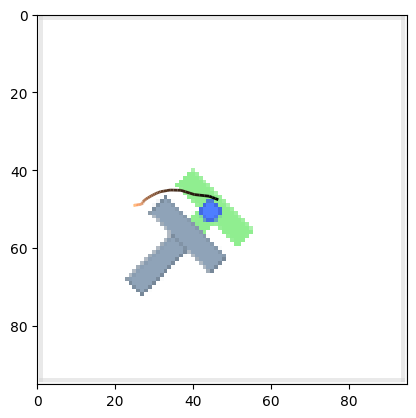

In [422]:
plt.figure()
# for i in range(len(all_positions)):
plot_path(*all_positions[-1][0, :16].T/(500/92))
plt.imshow(images[0].transpose(1, 2, 0))
ax = plt.gca()
ax.set_aspect('equal')
ax.set_xlim(0, 95)
ax.set_ylim(0, 95)
ax.invert_yaxis()

In [404]:
all_positions[-1][0, :10].T

tensor([[251.2356, 240.4514, 232.6755, 219.6128, 211.1502, 198.6070, 192.7806,
         186.1990, 175.8597, 170.3444],
        [260.8024, 256.5766, 248.8935, 248.5202, 247.1126, 252.5818, 253.8776,
         259.1340, 259.6776, 258.0769]])

In [337]:
all_positions[0].shape

torch.Size([1, 64, 2])

In [341]:
all_positions[0][0, :10].T

tensor([[ 4.0903e+02,  1.3432e+02,  3.3712e+02,  6.2615e+02,  3.3714e+02,
          1.7293e+02,  5.1443e+02,  2.3986e+02,  3.8816e-02, -1.6645e+02],
        [ 2.5369e+02,  2.8595e+00,  1.7962e+02,  1.7031e+02,  3.8079e+02,
          3.8573e+02,  5.1649e+02,  4.3642e+02,  2.6719e+02,  4.1318e+02]])